In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import sys
sys.path.append("..")
#import os
from utils.model import Net_mask
#from utils.data import Data
#from utils.loss_experiment import Loss
#from scripts.parameters import get_parameters
import torch
#import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal

In [15]:
model_map = Net_mask()
model_map_e4 = Net_mask()
model_map_e5 = Net_mask()
model_map.load_state_dict(torch.load(f'../saved_models/models_infinite_data/ML/model_weights.pth'))
model_map_e4.load_state_dict(torch.load(f'../saved_models/models_finite_data/e4/prior_100/model_weights.pth'))
model_map_e5.load_state_dict(torch.load(f'../saved_models/models_finite_data/e5/prior_100/model_weights.pth'))

<All keys matched successfully>

In [16]:
tensor_D = torch.tensor(
    [[1, -1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, -1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0,  1, -1, 0, 0, 0, 0, 0, 0],
    [0, 0,  0, 1, -1, 0, 0, 0, 0, 0],
    [0, 0,  0, 0, 1, -1, 0, 0, 0, 0],
    [0, 0,  0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0,  0, 0, 0, 0, 1, -1, 0, 0],
    [0, 0,  0, 0, 0, 0, 0, 1, -1, 0],
    [0, 0,  0, 0, 0, 0, 0, 0, 1, -1],
    [-1, 0, 0, 0, 0, 0, 0, 0, 0, 1],], dtype=torch.float
)
tensor_Q_m  = torch.mm(torch.t(tensor_D), tensor_D)
n_param = tensor_D.size(dim=0)
#tau2 = 1000 # 1/tau2 is the noise added to the diagonal
#tensor_Q_m_modified = tensor_Q_m + torch.eye(n_param)*(1./tau2)
#sigma2_eps = 0.01  # 1/sigma2_eps is the factor before the likelihood
#tensor_mu_m = torch.zeros(n_param)

#tensor_Sigma_m = torch.inverse(tensor_Q_m_modified)
#tensor_Sigma_eps = torch.eye(n_param)*sigma2_eps
#tensor_mu_eps = tensor_mu_m 

In [17]:
def loss(tensor_input, tensor_output):
    tensor_Psi = tensor_output
    tensor_Gd = tensor_input[:,:n_param]
    tensor_mask = tensor_input[:,n_param:]
    tensor_GPsi = tensor_Psi*tensor_mask

    # data residual loss
    tensor_squared_error = torch.square(tensor_GPsi - tensor_Gd)
    tensor_squared_error_sum = torch.sum(tensor_squared_error, [0, 1])
    tensor_data_fit_loss = tensor_squared_error_sum
    tensor_data_fit_loss *= 1/0.01

    # data regularization loss
    tensor_PsiQ_m = torch.matmul(tensor_Psi, tensor_Q_m)
    tensor_PsiQ_m = torch.unsqueeze(tensor_PsiQ_m, 1)
    tensor_Psi = torch.unsqueeze(tensor_Psi, 2)
    tensor_PsiQ_mPsi = torch.bmm(tensor_PsiQ_m, tensor_Psi).squeeze(2)
    tensor_data_regularization_loss = torch.sum(tensor_PsiQ_mPsi)

    return tensor_data_fit_loss + tensor_data_regularization_loss

In [18]:
all_test_obses = torch.load(f'../data/test_observations/test_set_full/all_test_obses.pt')
all_test_solutions = torch.load(f'../data/test_observations/test_set_full/all_test_solutions.pt')

In [19]:
print(all_test_obses.shape)
all_test_solutions.shape

torch.Size([6, 1000, 20])


torch.Size([6, 1000, 10])

In [20]:
n_points_max = 6
n_point = 1
n_data = 1000
n_bnn = 1
n_param = 10
map_prediction = torch.zeros(n_points_max, n_data, n_param)
map_prediction_e4 = torch.zeros(n_points_max, n_data, n_param)
map_prediction_e5 = torch.zeros(n_points_max, n_data, n_param)
bnn_e5_prediction = torch.zeros(n_points_max, n_bnn, n_data, n_param)
bnn_e4_prediction = torch.zeros(n_points_max, n_bnn, n_data, n_param)
loss_analytical = torch.zeros(n_points_max, n_data)
loss_map = torch.zeros(n_points_max, n_data)
loss_map_e4 = torch.zeros(n_points_max, n_data)
loss_map_e5 = torch.zeros(n_points_max, n_data)
loss_bnn_e5 = torch.zeros(n_points_max, n_bnn, n_data)
loss_bnn_e4 = torch.zeros(n_points_max, n_bnn, n_data)

model_map = Net_mask()
model_map.load_state_dict(torch.load(f'../saved_models/models_infinite_data/MAP_inf_prior_100/model_weights.pth'))

for n_p in range(n_points_max):
    for i in range(n_data):
        obs = all_test_obses[n_p,i]
        map_prediction[n_p,i,:] = model_map(obs)
        map_prediction_e4[n_p,i,:] = model_map_e4(obs)
        map_prediction_e5[n_p,i,:] = model_map_e5(obs)
        loss_map[n_p,i] = loss(obs.unsqueeze(0), map_prediction[n_p,i,:].unsqueeze(0))
        loss_map_e4[n_p,i] = loss(obs.unsqueeze(0), map_prediction_e4[n_p,i,:].unsqueeze(0))
        loss_map_e5[n_p,i] = loss(obs.unsqueeze(0), map_prediction_e5[n_p,i,:].unsqueeze(0))
        loss_analytical[n_p,i] = loss(obs.unsqueeze(0), all_test_solutions[n_p,i].unsqueeze(0))
        
        for i_bnn in range(n_bnn):
            model_bnn_e5 = Net_mask()
            model_bnn_e5.load_state_dict(torch.load(f'../saved_models/rml/long/e5/pos/{i_bnn}/model_weights.pth'))
            bnn_e5_prediction[n_p,i_bnn,i,:] = model_bnn_e5(obs)
            loss_bnn_e5[n_p,i_bnn,i] = loss(obs.unsqueeze(0), bnn_e5_prediction[n_p,i_bnn,i,:].unsqueeze(0))
            model_bnn_e4 = Net_mask()
            model_bnn_e4.load_state_dict(torch.load(f'../saved_models/rml/long/e4/pos/{i_bnn}/model_weights.pth'))
            bnn_e4_prediction[n_p,i_bnn,i,:] = model_bnn_e4(obs)
            loss_bnn_e4[n_p,i_bnn,i] = loss(obs.unsqueeze(0), bnn_e4_prediction[n_p,i_bnn,i,:].unsqueeze(0))


In [21]:
print(bnn_e5_prediction[0].shape)
torch.mean(bnn_e5_prediction[0]).shape

torch.Size([1, 1000, 10])


torch.Size([])

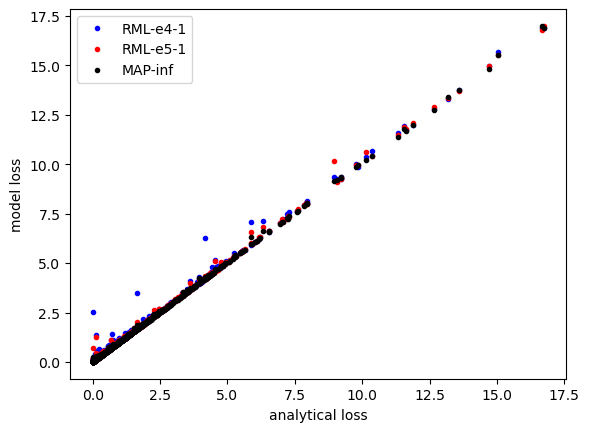

In [22]:
n_points = 3
#plt.plot(loss_analytical[1], loss_map[1])
plt.plot(loss_analytical[1].detach(), loss_bnn_e4[1,0,:].detach(), 'b.')
plt.plot(loss_analytical[1].detach(), loss_bnn_e5[1,0,:].detach(), 'r.')
plt.plot(loss_analytical[1].detach(), loss_map[1].detach(), 'k.')
plt.legend(['RML-e4-1', 'RML-e5-1', 'MAP-inf'])
#plt.title(f'Loss 1000 observations, {n_points} data points')
plt.xlabel('analytical loss')
plt.ylabel('model loss')
plt.savefig(f'../figures/plot_loss_analytical_vs_predicted/plot_loss_analytical_vs_predicted_RML.png')

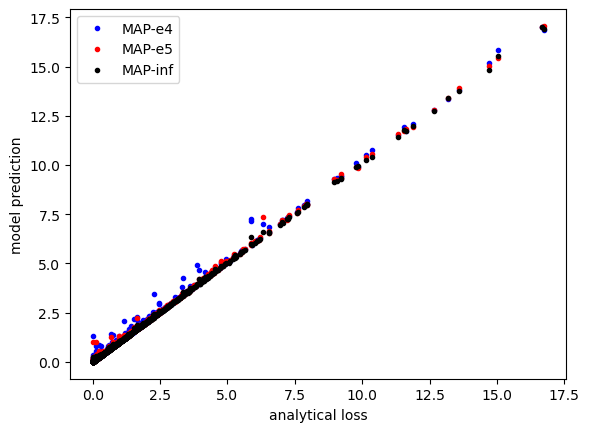

In [23]:
n_points = 3
#plt.plot(loss_analytical[1], loss_map[1])
plt.plot(loss_analytical[1].detach(), loss_map_e4[1].detach(), 'b.')
plt.plot(loss_analytical[1].detach(), loss_map_e5[1].detach(), 'r.')
plt.plot(loss_analytical[1].detach(), loss_map[1].detach(), 'k.')
plt.legend(['MAP-e4', 'MAP-e5', 'MAP-inf'])
#plt.title(f'Loss 1000 observations, {n_points} data points')
plt.xlabel('analytical loss')
plt.ylabel('model prediction')
plt.savefig(f'../figures/plot_loss_analytical_vs_predicted/plot_loss_analytical_vs_predicted_MAP.png')